In [1]:
import subprocess
try:
    gpu_info = subprocess.check_output('nvidia-smi', shell=True).decode()
    print('GPU detected:')
    # Print just the relevant lines
    for line in gpu_info.split('\n')[:12]:
        print(line)
except Exception:
    print('No GPU detected — go to Runtime > Change runtime type > GPU')
    print('    XGBoost will fall back to CPU if device=cuda is unavailable.')

GPU detected:
Sat Feb 21 03:04:38 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   74C    P0             34W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------------

In [2]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import joblib

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120

In [3]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH   = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_data/'
OUTPUT_PATH = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/'
MODELS_PATH = '/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/'

os.makedirs(OUTPUT_PATH, exist_ok=True)
print(f'Output directory ready: {OUTPUT_PATH}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Output directory ready: /content/drive/MyDrive/SU Works/CPSC_5310_Project/docs/figures/


In [5]:
train_df = pd.read_parquet(DATA_PATH + 'baseline_training.parquet')
test_df  = pd.read_parquet(DATA_PATH + 'baseline_testing.parquet')

print(f'Train shape : {train_df.shape}')
print(f'Test  shape : {test_df.shape}')
print(f'\nClass distribution (train):')
print(train_df['revenue_class'].value_counts().sort_index())

Train shape : (233850, 44)
Test  shape : (39445, 44)

Class distribution (train):
revenue_class
1    26850
2    51162
3    51092
4    51808
5    52938
Name: count, dtype: int64


In [6]:
TARGET_COL = 'revenue_class'
COLS_TO_EXCLUDE = [TARGET_COL, 'timestamp', 'hour', 'day_of_week']

X_train = train_df.drop(columns=COLS_TO_EXCLUDE)
y_train = train_df[TARGET_COL]
X_test  = test_df.drop(columns=COLS_TO_EXCLUDE)
y_test  = test_df[TARGET_COL]

In [7]:
# revenue_class is 1–5, XGBoost expects 0–4, we subtract 1 for training
# and add 1 back after prediction
y_train_xgb = y_train - 1
y_test_xgb  = y_test  - 1

In [8]:
CATEGORICAL_FEATURES = ['pickup_cluster']
NUMERIC_FEATURES = [
    col for col in X_train.select_dtypes(include=np.number).columns
    if col not in CATEGORICAL_FEATURES
]

# Pipeline

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    f1_score,
)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import TargetEncoder

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(random_state=RANDOM_STATE), CATEGORICAL_FEATURES),
    ],
    remainder='passthrough',          # XGBoost is scale-invariant
    verbose_feature_names_out=False,
)

X_train_enc = preprocessor.fit_transform(X_train, y_train_xgb)
X_test_enc  = preprocessor.transform(X_test)

print(f'Encoded train shape: {X_train_enc.shape}')
print(f'Encoded test shape : {X_test_enc.shape}')

Encoded train shape: (233850, 44)
Encoded test shape : (39445, 44)


In [11]:
from scipy.stats import randint, uniform
from xgboost import XGBClassifier

In [12]:
tscv = TimeSeriesSplit(n_splits=3)

param_distributions = {
    'max_depth'        : randint(3, 11),        # 3 to 10 inclusive
    'learning_rate'    : uniform(0.01, 0.29),   # 0.01 to 0.30
    'subsample'        : uniform(0.6, 0.4),     # 0.6 to 1.0
    'colsample_bytree' : uniform(0.6, 0.4),     # 0.6 to 1.0
    'reg_alpha'        : uniform(0.0, 1.0),     # L1
    'reg_lambda'       : uniform(0.5, 2.5),     # L2
}

In [13]:
# Base estimator used during search — n_estimators capped at 300
# early_stopping_rounds prevents overfit trees within each CV fold
search_estimator = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    n_estimators=300,
    tree_method='hist',
    device='cuda',
    eval_metric='merror',
    early_stopping_rounds=30,
    random_state=RANDOM_STATE,
    verbosity=0,              # suppress per-tree output during search
)

In [14]:
random_search = RandomizedSearchCV(
    estimator=search_estimator,
    param_distributions=param_distributions,
    n_iter=15,
    cv=tscv,
    scoring='accuracy',
    verbose=2,                # shows candidate + fold progress
    random_state=RANDOM_STATE,
    refit=False,              # we refit manually below with early stopping on full train
    return_train_score=True,
)

In [15]:
t0 = time.time()

random_search.fit(
    X_train_enc, y_train_xgb,
    eval_set=[(X_test_enc, y_test_xgb)],
    verbose=False,
)

search_time = time.time() - t0
print(f'Search complete in {search_time/60:.1f} min')

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.28570714885887566, max_depth=5, reg_alpha=0.7796910002727693, reg_lambda=1.9921253948662174, subsample=0.7783331011414365; total time=   1.7s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.28570714885887566, max_depth=5, reg_alpha=0.7796910002727693, reg_lambda=1.9921253948662174, subsample=0.7783331011414365; total time=   2.3s
[CV] END colsample_bytree=0.749816047538945, learning_rate=0.28570714885887566, max_depth=5, reg_alpha=0.7796910002727693, reg_lambda=1.9921253948662174, subsample=0.7783331011414365; total time=   3.6s
[CV] END colsample_bytree=0.6399899663272012, learning_rate=0.14318217867010147, max_depth=7, reg_alpha=0.6011150117432088, reg_lambda=2.2701814444901136, subsample=0.608233797718321; total time=   2.0s
[CV] END colsample_bytree=0.6399899663272012, learning_rate=0.14318217867010147, max_depth=7, reg_alpha=0.6011150117432088, reg

In [16]:
# CV Results Summary
cv_results = (
    pd.DataFrame(random_search.cv_results_)
    .sort_values('mean_test_score', ascending=False)
    .reset_index(drop=True)
)

best_params = random_search.best_params_

print('=' * 55)
print('  Hyperparameter Search Results')
print('=' * 55)
print(f'  Best CV Accuracy : {random_search.best_score_:.4f}')
print(f'  Best parameters  :')
for k, v in best_params.items():
    print(f'    {k:<22}: {v:.4f}' if isinstance(v, float) else f'    {k:<22}: {v}')
print()

print('Top 5 candidates:')
display(
    cv_results[[
        'mean_test_score', 'std_test_score', 'mean_train_score',
        'param_max_depth', 'param_learning_rate', 'param_subsample'
    ]].head(5).rename(columns={
        'mean_test_score' : 'Val Acc',
        'std_test_score'  : 'Std',
        'mean_train_score': 'Train Acc',
        'param_max_depth' : 'max_depth',
        'param_learning_rate': 'lr',
        'param_subsample' : 'subsample',
    }).round(4)
)

  Hyperparameter Search Results
  Best CV Accuracy : 0.7825
  Best parameters  :
    colsample_bytree      : 0.9687
    learning_rate         : 0.0357
    max_depth             : 9
    reg_alpha             : 0.5208
    reg_lambda            : 2.9029
    subsample             : 0.9378

Top 5 candidates:


,Val Acc,Std,Train Acc,max_depth,lr,subsample
0,0.7825,0.0058,0.8643,9,0.0357,0.9378
1,0.7819,0.0063,0.8535,7,0.1432,0.6082
2,0.7819,0.0063,0.8118,4,0.2021,0.8271
3,0.7818,0.0060,0.9063,8,0.1162,0.7530
4,0.7816,0.0056,0.8477,6,0.2543,0.8392


In [17]:
best_model = XGBClassifier(
    objective='multi:softmax',
    num_class=5,
    n_estimators=1000,           # high ceiling — early stopping will find the right number
    tree_method='hist',
    device='cuda',
    eval_metric='merror',
    early_stopping_rounds=50,    # stop if no improvement for 50 consecutive rounds
    random_state=RANDOM_STATE,
    verbosity=1,
    **best_params
)

print('raining final model with best hyperparameters + early stopping...')
print(f'   Max trees : 1000  |  Early stop : 50 rounds  |  Device : GPU\n')

t0 = time.time()
best_model.fit(
    X_train_enc, y_train_xgb,
    eval_set=[(X_train_enc, y_train_xgb), (X_test_enc, y_test_xgb)],
    verbose=50,                  # print metrics every 50 rounds
)
train_time = time.time() - t0

optimal_trees = best_model.best_iteration + 1
print(f'\nraining complete in {train_time:.0f}s')
print(f'   Optimal number of trees (early stopping): {optimal_trees}')

raining final model with best hyperparameters + early stopping...
   Max trees : 1000  |  Early stop : 50 rounds  |  Device : GPU

[0]	validation_0-merror:0.29984	validation_1-merror:0.27836
[50]	validation_0-merror:0.19818	validation_1-merror:0.22449
[100]	validation_0-merror:0.18796	validation_1-merror:0.22099
[150]	validation_0-merror:0.18044	validation_1-merror:0.21823
[200]	validation_0-merror:0.17264	validation_1-merror:0.21701
[250]	validation_0-merror:0.16470	validation_1-merror:0.21536
[300]	validation_0-merror:0.15635	validation_1-merror:0.21422
[350]	validation_0-merror:0.14691	validation_1-merror:0.21270
[400]	validation_0-merror:0.13782	validation_1-merror:0.21209
[450]	validation_0-merror:0.12765	validation_1-merror:0.21083
[500]	validation_0-merror:0.11767	validation_1-merror:0.21019
[550]	validation_0-merror:0.10882	validation_1-merror:0.20994
[600]	validation_0-merror:0.10038	validation_1-merror:0.20956
[650]	validation_0-merror:0.09211	validation_1-merror:0.20958
[700

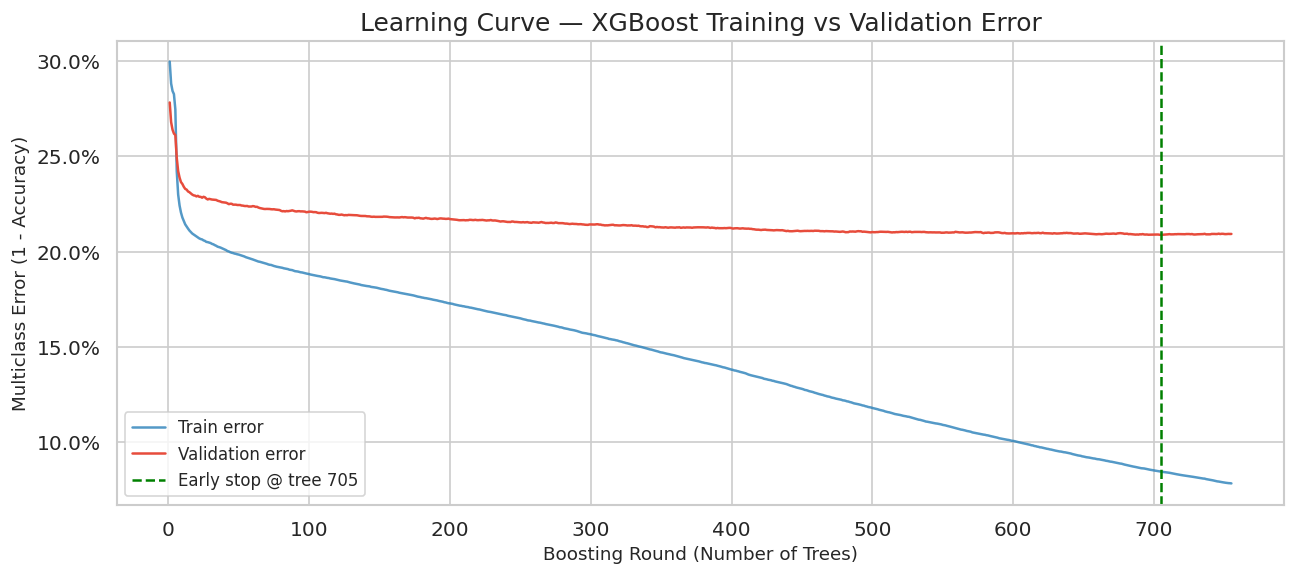

In [18]:
# Plot training vs validation error curve
results   = best_model.evals_result()
train_err = results['validation_0']['merror']
val_err   = results['validation_1']['merror']
rounds    = range(1, len(train_err) + 1)

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(rounds, train_err, label='Train error',      color='#2980b9', linewidth=1.5, alpha=0.8)
ax.plot(rounds, val_err,   label='Validation error', color='#e74c3c', linewidth=1.5)
ax.axvline(optimal_trees, color='green', linestyle='--', linewidth=1.5,
           label=f'Early stop @ tree {optimal_trees}')
ax.set_xlabel('Boosting Round (Number of Trees)', fontsize=11)
ax.set_ylabel('Multiclass Error (1 - Accuracy)', fontsize=11)
ax.set_title('Learning Curve — XGBoost Training vs Validation Error',
             fontsize=15)
ax.legend(fontsize=10)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
plt.tight_layout()
plt.show()

In [19]:
CLASS_LABELS = ['1: Quiet', '2: Steady', '3: Busy', '4: High Value', '5: Surge']

In [20]:
# Predict — restore from 0-indexed back to original 1–5 labels
y_pred_xgb = best_model.predict(X_test_enc)
y_pred     = y_pred_xgb + 1

test_accuracy = accuracy_score(y_test, y_pred)
test_mae      = mean_absolute_error(y_test, y_pred)
adjacent_acc  = np.mean(np.abs(y_test - y_pred) <= 1)
weighted_f1   = f1_score(y_test, y_pred, average='weighted')

print('=' * 60)
print('  Test Set Evaluation — XGBoost (tuned + early stopping)')
print('=' * 60)
print(f'  Accuracy               : {test_accuracy:.4f} ({test_accuracy*100:.2f}%)')
print(f'  MAE (ordinal)          : {test_mae:.4f}   [target: ≤ 0.80]')
print(f'  Adjacent Accuracy (±1) : {adjacent_acc:.4f} ({adjacent_acc*100:.2f}%)  [target: ≥ 90%]')
print(f'  Weighted F1            : {weighted_f1:.4f}   [target: ≥ 0.75]')
print(f'  Optimal trees used     : {optimal_trees}')
print('=' * 60)
print()
print('Per-class Report:')
print(classification_report(y_test, y_pred, target_names=CLASS_LABELS))

  Test Set Evaluation — XGBoost (tuned + early stopping)
  Accuracy               : 0.7912 (79.12%)
  MAE (ordinal)          : 0.2119   [target: ≤ 0.80]
  Adjacent Accuracy (±1) : 0.9974 (99.74%)  [target: ≥ 90%]
  Weighted F1            : 0.7908   [target: ≥ 0.75]
  Optimal trees used     : 705

Per-class Report:
               precision    recall  f1-score   support

     1: Quiet       0.76      0.69      0.72      2753
    2: Steady       0.77      0.80      0.79      8705
      3: Busy       0.76      0.74      0.75      9755
4: High Value       0.77      0.77      0.77      9462
     5: Surge       0.88      0.89      0.89      8770

     accuracy                           0.79     39445
    macro avg       0.79      0.78      0.78     39445
 weighted avg       0.79      0.79      0.79     39445



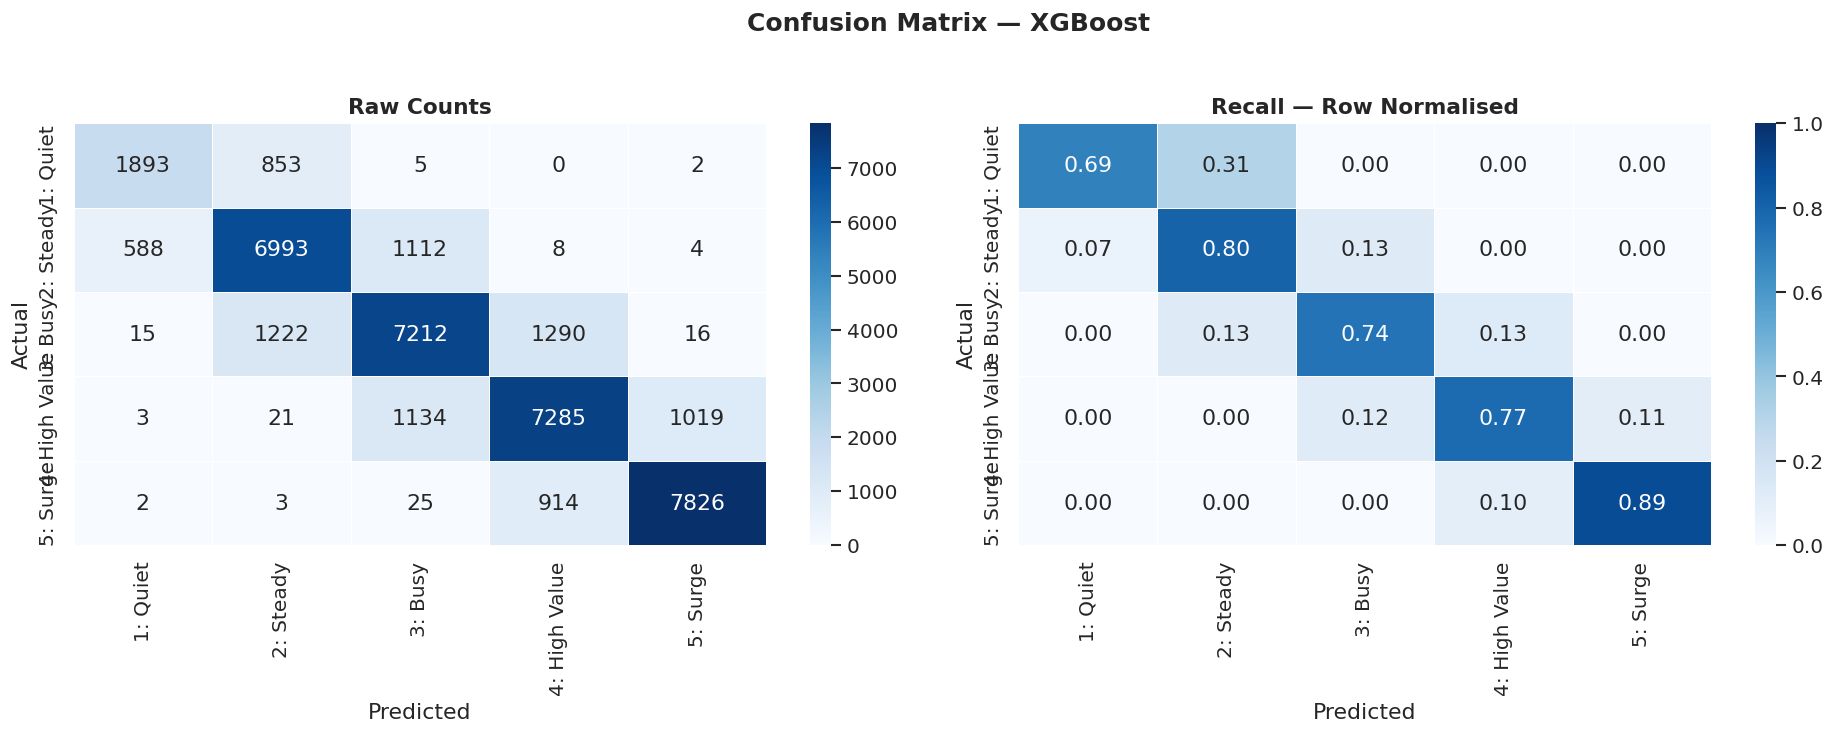

In [21]:
cm      = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=axes[0], linewidths=0.5,
)
axes[0].set_title('Raw Counts', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(
    cm_norm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=axes[1], linewidths=0.5, vmin=0, vmax=1,
)
axes[1].set_title('Recall — Row Normalised', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrix — XGBoost', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

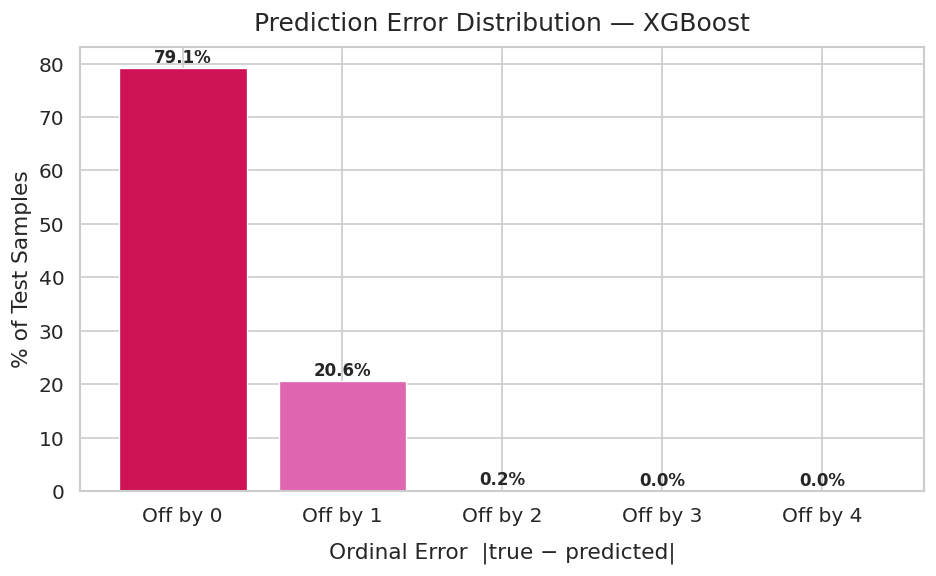

  Exact match       : 79.1%


In [22]:
# Cell 1: Prediction Error Distribution
errors       = np.abs(y_test.values - y_pred)
error_counts = pd.Series(errors).value_counts().sort_index()
error_pct    = error_counts / len(errors) * 100

plt.figure(figsize=(8, 5))

cmap_continuous = plt.get_cmap('PuRd_r')
cmap_discrete = cmap_continuous.resampled(5)
bars = plt.bar(
    error_pct.index, error_pct.values,
    color=cmap_discrete(np.linspace(0.3, 1, len(error_pct))), edgecolor='white', linewidth=0.8
)

plt.xlabel('Ordinal Error  |true − predicted|', fontsize=13, labelpad=10)
plt.ylabel('% of Test Samples', fontsize=13)
plt.title('Prediction Error Distribution — XGBoost', fontsize=15, pad=10)
plt.xticks(error_pct.index, [f'Off by {i}' for i in error_pct.index])

for bar, pct in zip(bars, error_pct.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'prediction_error_dist.svg', bbox_inches='tight', format='svg')
plt.show()

print(f'  Exact match       : {error_pct.get(0, 0):.1f}%')

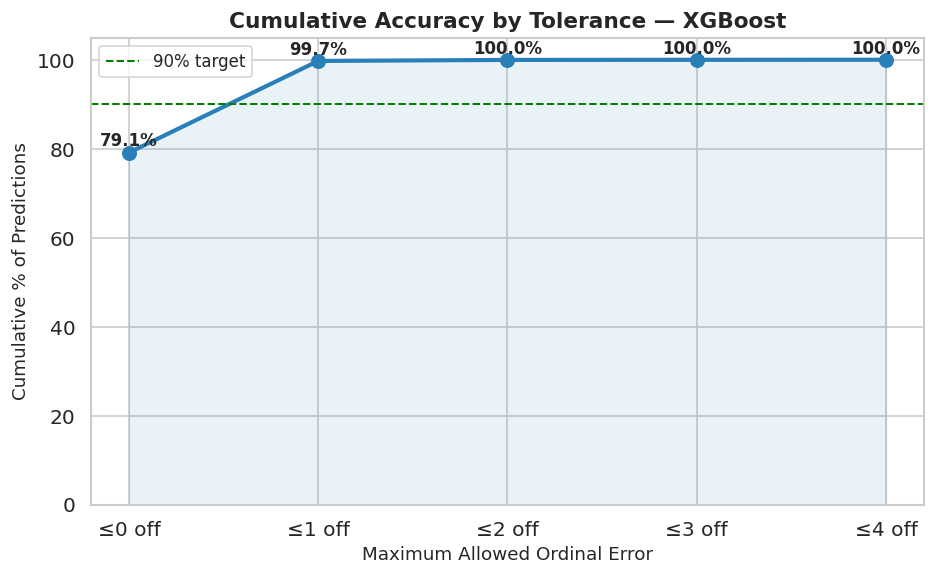

  Within ±1 class   : 99.7%
  Within ±2 classes : 100.0%


In [23]:
# Cell 2: Cumulative Accuracy by Tolerance
errors       = np.abs(y_test.values - y_pred)
error_counts = pd.Series(errors).value_counts().sort_index()
error_pct    = error_counts / len(errors) * 100
cum_pct      = error_pct.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(cum_pct.index, cum_pct.values, marker='o', color='#2980b9',
             linewidth=2.5, markersize=8)
plt.axhline(90, color='green', linestyle='--', linewidth=1.2, label='90% target')
plt.fill_between(cum_pct.index, cum_pct.values, alpha=0.1, color='#2980b9')

plt.xlabel('Maximum Allowed Ordinal Error', fontsize=11)
plt.ylabel('Cumulative % of Predictions', fontsize=11)
plt.title('Cumulative Accuracy by Tolerance — XGBoost', fontsize=13, fontweight='bold')
plt.xticks(cum_pct.index, [f'≤{i} off' for i in cum_pct.index])
plt.ylim(0, 105)
plt.legend(fontsize=10)

for x, y in zip(cum_pct.index, cum_pct.values):
    plt.text(x, y + 1.5, f'{y:.1f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f'  Within ±1 class   : {cum_pct.get(1, 0):.1f}%')
print(f'  Within ±2 classes : {cum_pct.get(2, 0):.1f}%')

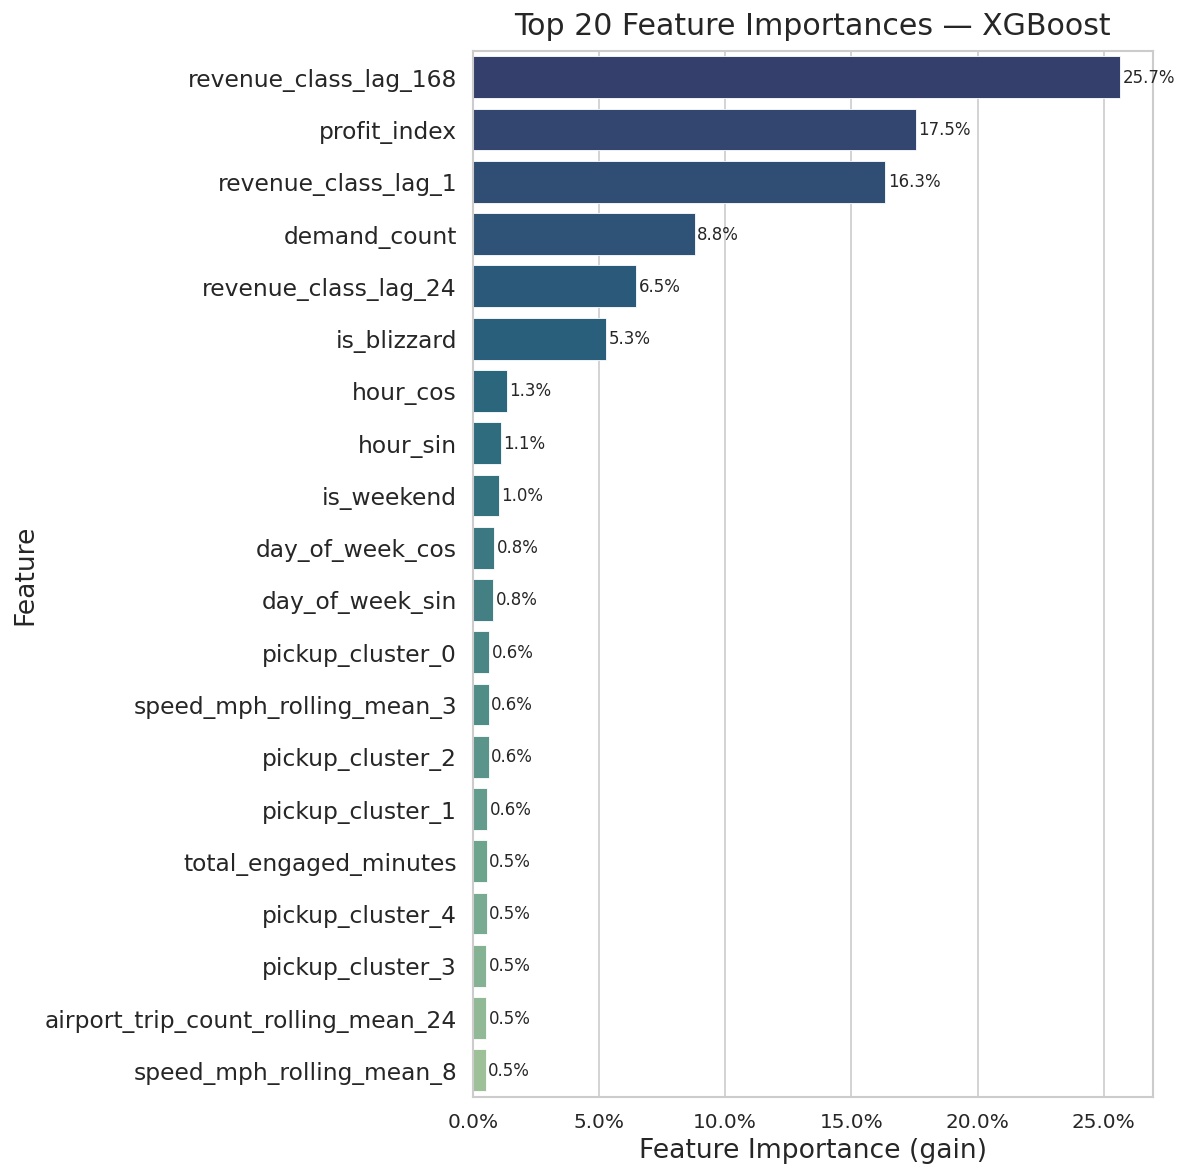

Top 5 features account for 74.8% of total importance


In [24]:
feature_names = preprocessor.get_feature_names_out()
importances   = best_model.feature_importances_

imp_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

TOP_N   = 20
top_imp = imp_df.head(TOP_N)
colors  = sns.color_palette("crest_r", n_colors=TOP_N)

fig, ax = plt.subplots(figsize=(10, 10))

# Use seaborn.barplot for a prettier plot
bars = sns.barplot(
    x='Importance',
    y='Feature',
    data=top_imp,
    hue='Feature', # Assign 'Feature' to hue for coloring
    palette=colors, # Apply the generated color palette
    edgecolor='white',
    linewidth=0.5,
    ax=ax,
    legend=False # Disable legend as colors are explicitly mapped
)

# Add text labels to the bars
for bar in bars.patches:
    width = bar.get_width()
    ax.text(width + 0.001, bar.get_y() + bar.get_height() / 2,
            f'{width*100:.1f}%', va='center', fontsize=10)

ax.set_xlabel('Feature Importance (gain)', fontsize=16)
ax.set_ylabel('Feature', fontsize=16) # Explicitly set y-label with increased fontsize
ax.set_title(f'Top {TOP_N} Feature Importances — XGBoost',
             fontsize=18, pad=10)
ax.xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_PATH + 'feature_importance.svg', bbox_inches='tight', format='svg')
plt.show()

print(f'Top 5 features account for {imp_df["Importance"].head(5).sum()*100:.1f}% of total importance')

In [28]:
joblib.dump(best_model,   MODELS_PATH + 'xgb_best_model.pkl')
joblib.dump(preprocessor, MODELS_PATH + 'xgb_preprocessor.pkl')

['/content/drive/MyDrive/SU Works/CPSC_5310_Project/saved_models/xgb_preprocessor.pkl']

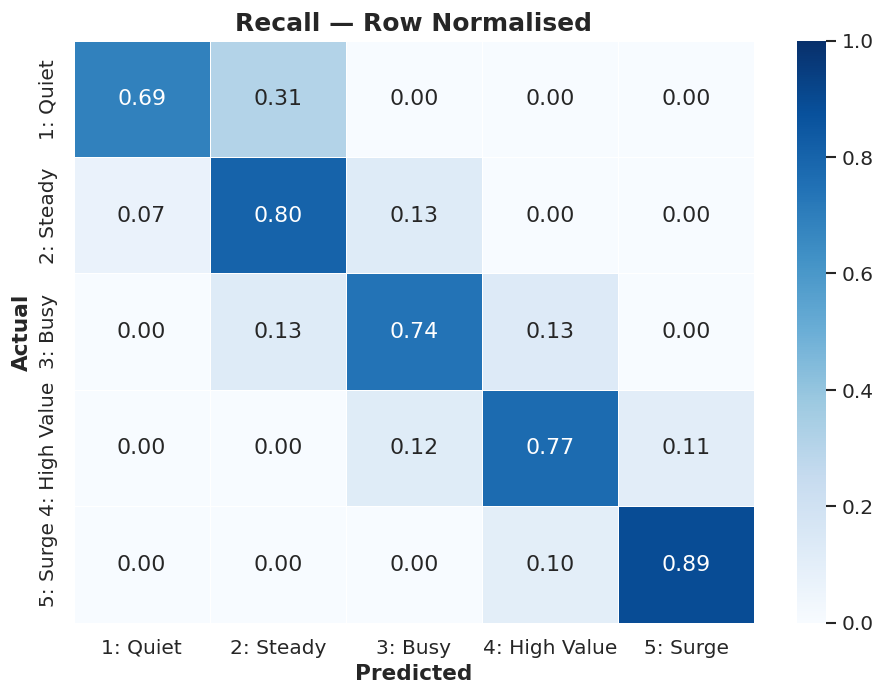

In [26]:
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(
    cm_norm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=ax, linewidths=0.5, vmin=0, vmax=1,
)
ax.set_title('Recall — Row Normalised', fontsize=15, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
ax.set_ylabel('Actual', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

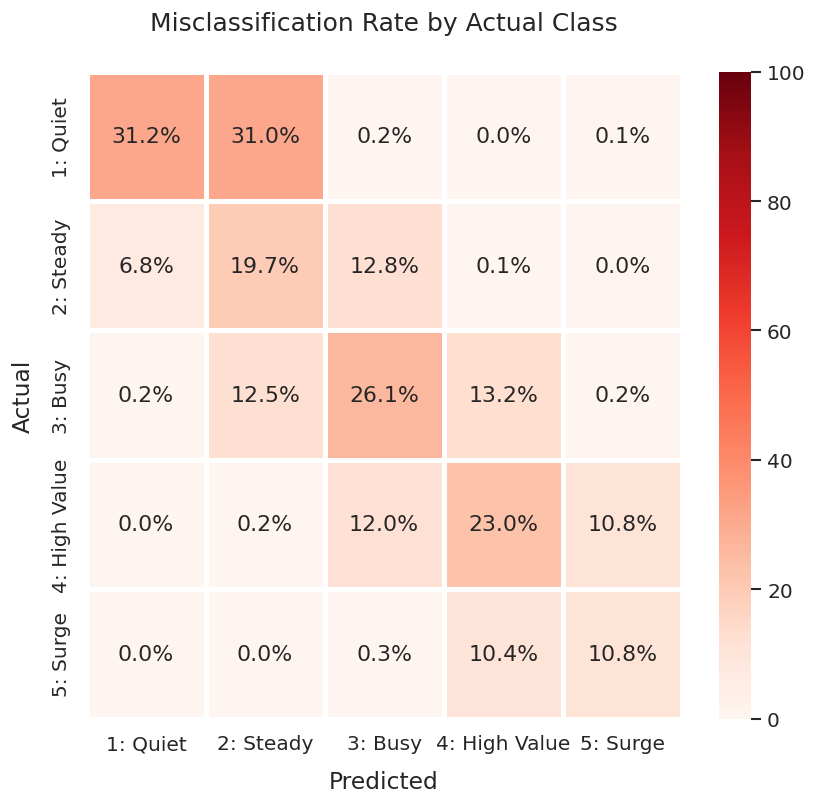

In [27]:
misclassification_matrix = cm_norm.copy()

# For each row (actual class), the diagonal now represents the percentage of misclassifications
# 1 - recall for each class
for i in range(misclassification_matrix.shape[0]):
    misclassification_matrix[i, i] = 1 - cm_norm[i, i]

# Convert to DataFrame for easier string formatting
misclassification_df = pd.DataFrame(misclassification_matrix * 100,
                                      index=CLASS_LABELS, columns=CLASS_LABELS)

# Apply string formatting with percentage sign
annot_data = misclassification_df.map(lambda x: f'{x:.1f}%')

fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(
    misclassification_df, # Use the numeric data for coloring
    annot=annot_data,     # Use the string-formatted data for annotations
    fmt='s',              # Specify that annotations are strings
    cmap='Reds',
    xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS,
    ax=ax, linewidths=3, vmin=0, vmax=100,
)
ax.set_title('Misclassification Rate by Actual Class', fontsize=15, pad=25)
ax.set_xlabel('Predicted', fontsize=14, labelpad=10)
ax.set_ylabel('Actual', fontsize=14, labelpad=10)
plt.savefig(OUTPUT_PATH + 'misclassification_rate_xgb.svg', bbox_inches='tight', format='svg')
plt.show()